# Sign Lenguage MNIST

**Universitario:** Pinto Barrón Osvaldo Dennis.

**Carrera:** Ingeniería en Diseño y Animación Digital.

**Temática del dataset:** Representación gráfica del lenguaje de señas americano, excluyendo las letras J y Z debido a los movimientos gestuales.

**Enlace del dataset:**  [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

**Formato:** Está diseñado para coincidir estrechamente con el MNIST clásico. Cada caso de entrenamiento y prueba representa una etiqueta (0-24) como un mapa uno a uno para cada letra del alfabeto de la A a la Z (y no hay casos para 9=J o 25=Z debido a los movimientos gestuales).

El dataset se divide de la siguiente forma:


*   Datos de entrenamiento (27.455 casos).
*   Datos de prueba (7172 casos).



Columnas usadas para la realización de la clasificación:



*   **Variables de entrada:** Se usan 784 columnas, que tienen los pixeles de las imágenes a escala de grises con valores que van desde el 0 al 255.
*   **Variable de salida:**
Contiene la etiqueta que va del 0 al 24, representando una letra del abecedario (A-Z) a través del lenguaje de señas.






# Clasificación Multiclase (One vs All)

## Introducción

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

In [1]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Manejo de datos
import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# Librería para realizar gráficos
import matplotlib.pyplot as plt

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

from scipy.interpolate import make_interp_spline

# Importación de archivos desde la nube de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 Cargamos los datos de entrenamiento
Los datos de entrenamiento del dataset **sign_mnist_train.csv** poseen 27.455 datos.


In [2]:
# Ingresar imágenes de dígitos de 28x28
input_layer_size  = 784

# Tenemos 25 etiquetas (0-24)
num_labels = 25

#  Cargamos los datos de entrenamiento
data = pd.read_csv('/content/drive/MyDrive/Datasets/sign_mnist_train.csv')

# Asignamos valores a X y Y
X = data.iloc[:, 1:].values # Toma en cuenta todas las columnas a excepción de la primera
y = data.iloc[:, 0].values # Toma la primera columna

m = y.size

# Comprobamos los tamaños
print('Tamaño de X:', X.shape)
print('Tamaño de y:', y.shape)

Tamaño de X: (27455, 784)
Tamaño de y: (27455,)


### 1.1 Visualización de los datos

Creamos la función **displayData** para representar gráficamente las dimensiones de las imágenes de tamaño 28x28 pixeles.

In [3]:
def displayData(X, example_width=None, figsize=(10, 10)):

    X = np.array(X)  # Convertir a arreglo de numpy

    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Check if the index is within bounds
        if i < m:
            ax.imshow(X[i].reshape(example_width, example_width, order='C'),
                      cmap='Greys', extent=[0, 1, 0, 1], aspect='equal', origin='upper')
        ax.axis('off')

Visualizamos 100 datos de forma aleatoria.

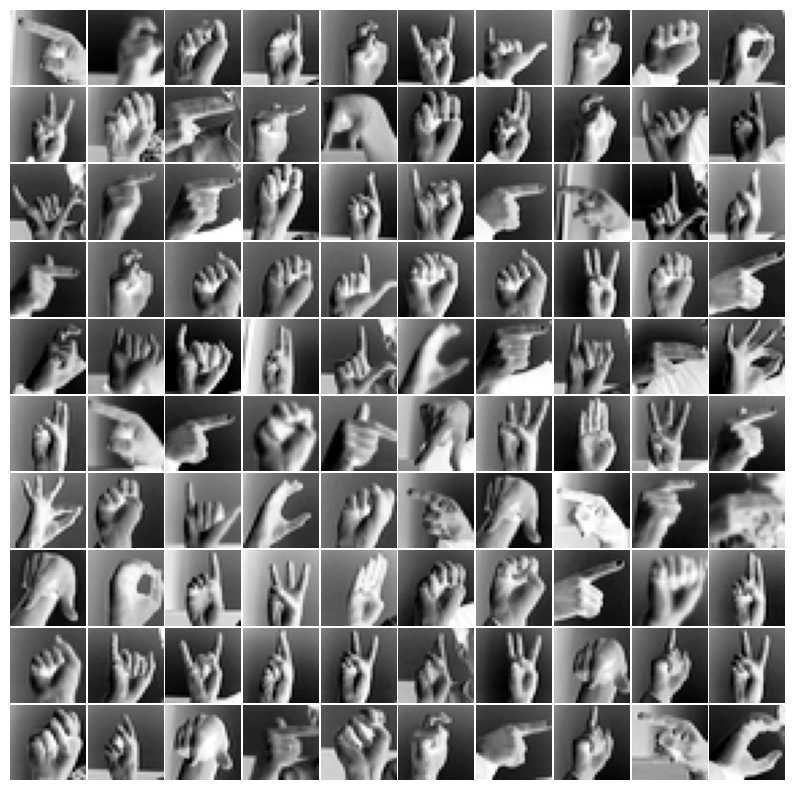

In [4]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
X_img = X[rand_indices, :]

displayData(X_img)

### 1.2 Vectorización de regresión logística

Se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 25 clases, deberá entrenar 25 clasificadores de regresión logística separados. Para que esta capacitación sea eficiente, es importante asegurarse de que el código esté bien vectorizado.

En esta sección, se implementará una versión vectorizada de regresión logística que no emplea ningún bucle "for".

Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

In [5]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 3


#### 1.2.1 Vectorización de la funcion de costo
Creamos la función de la sigmoide.

In [6]:
def sigmoid(z):

    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

Creamos la función del costo y el gradiente.

In [7]:
def lrCostFunction(theta, X, y, lambda_):
    m = y.size

    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    # Evitar valores de h que sean 0 o 1
    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)

    temp = theta.copy()
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad


#### 1.2.3 Vectorización regularizada de la regresión logística

Una vez implementada la vectorización para la regresión logística, corresponde agregarar regularización a la función de costo.


In [8]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo: {:.6f}'.format(J))
print('-----------------------')
print('Gradientes calculados:')
for i, val in enumerate(grad, 1):
    print(f'Gradiente {i}: {val:.6f}')

Costo: 2.534819
-----------------------
Gradientes calculados:
Gradiente 1: 0.146561
Gradiente 2: -0.548558
Gradiente 3: 0.724722
Gradiente 4: 1.398003


### 1.3 Clasificacion One-vs-all
En esta parte del ejercicio, se implementará la clasificación de uno contra todos mediante el entrenamiento de múltiples clasificadores de regresión logística regularizados, uno para cada una de las clases en nuestro conjunto de datos.

También haremos uso de la función para graficar el costo.

*   **cost_histories:** Inicializa una lista de listas para almacenar el costo de la función de costo en cada iteración para cada clase.

*   **callback** es una función interna que se llama después de cada iteración. Calcula el costo actual y lo agrega a la lista cost_histories correspondiente.






In [9]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Añadir columna de unos para el término de sesgo

    cost_histories = [[] for _ in range(num_labels)]  # Lista de listas para almacenar el costo por iteración para cada clase

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 100, 'disp': False}

        # Función callback para almacenar el costo en cada iteración
        def callback(theta):
            cost, _ = lrCostFunction(theta, X, (y == c), lambda_)
            cost_histories[c].append(cost)

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                args=(X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                callback=callback,  # Usar el callback aquí
                                options=options)

        all_theta[c] = res.x

        print(f'Theta para la clase {c}: {res.x}')

    return all_theta, cost_histories

Agregamos un valor de lambda y llamamos a la función

In [10]:
lambda_ = 0.01
all_theta, cost_histories  = oneVsAll(X, y, num_labels, lambda_)


Theta para la clase 0: [-2.58879467e-04  9.14214599e-03  7.41783140e-03  3.55149373e-03
  1.95980328e-03  5.67274446e-04  8.21931895e-04  6.97406243e-04
  1.08518363e-03  3.98976963e-04  2.91640804e-04  1.00616626e-03
  8.26980423e-04  1.34273980e-03  1.30236132e-04 -1.40506635e-03
 -2.29815174e-03 -2.81813434e-03 -2.96619842e-03 -2.53249269e-03
 -2.49154354e-03 -2.45142746e-03 -2.45822542e-03 -1.33131155e-03
  1.11647733e-03  1.81636484e-03  2.82382089e-03  4.36350919e-03
  4.16142639e-03  8.32890066e-03  6.04696027e-03  2.78667471e-03
  9.29072757e-04 -9.39422258e-04 -1.51340887e-04  1.08070746e-04
 -1.68417859e-04 -1.10425855e-03  1.13612009e-03  6.57529486e-04
 -1.86745080e-05  1.35588405e-03 -1.00805480e-03 -2.54391114e-03
 -2.53014648e-03 -3.02319823e-03 -2.93254110e-03 -2.00265063e-03
 -2.49793947e-03 -2.12711156e-03 -2.33539473e-03 -2.84451278e-03
 -1.35214889e-03  2.28799004e-03  3.51461021e-03  2.49129509e-03
  2.57436936e-03  7.81935913e-03  5.12095395e-03  1.87378704e-03
 -

#### 1.3.1 Gráfica del costo
Creamos la siguiente función:
*   **plot_cost(cost_histories):** Función para graficar la evolución del costo a lo largo de las iteraciones.


In [11]:
def plot_cost(cost_histories):
    plt.figure(figsize=(12, 8))
    for i in range(num_labels):
        plt.plot(cost_histories[i], label=f'Clase {i}')
    plt.xlabel('Número de iteraciones')
    plt.ylabel('Costo')
    plt.title('Costo durante la optimización para cada clase')
    plt.legend()
    plt.show()

Llamamos a la función.

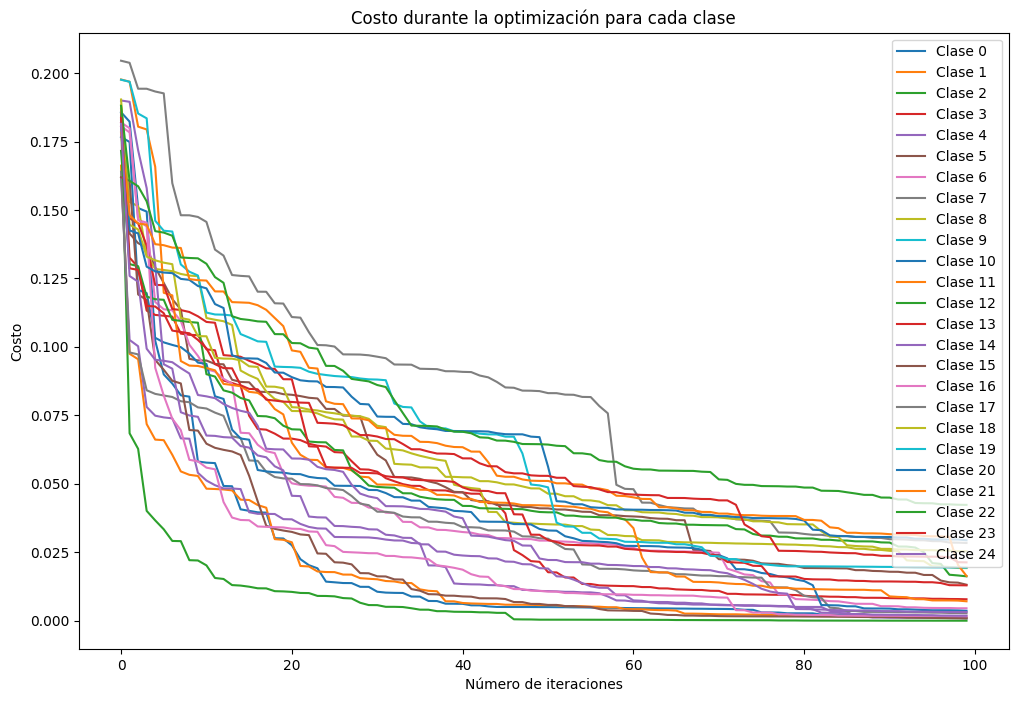

In [20]:
plot_cost(cost_histories)

### 1.4 Prediccion One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados.

In [13]:
def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Añade una columna de 1
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

#### 1.4.1 Cargamos los datos de prueba
Los datos de prueba del dataset **sign_mnist_test.csv** poseen 7172 datos.


In [14]:
#  Cargamos los datos de entrenamiento
data_test = pd.read_csv('/content/drive/MyDrive/Datasets/sign_mnist_test.csv')

# Asignamos valores a X y Y
X_test = data_test.iloc[:, 1:].values # Toma en cuenta todas las columnas a excepción de la primera
y_test = data_test.iloc[:, 0].values # Toma la primera columna

m_test = y_test.size

# Comprobamos los tamaños
print('Tamaño de X:', X_test.shape)
print('Tamaño de y:', y_test.shape)

Tamaño de X: (7172, 784)
Tamaño de y: (7172,)


#### 1.4.2 Precisión y predicción
Precisión con el 80% de los datos.

In [15]:
pred_train = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred_train == y) * 100))

Precision del conjuto de entrenamiento: 99.73%


Precisión con el 20% de los datos.

In [16]:
pred_test = predictOneVsAll(all_theta, X_test)
print('Precision del conjuto de prueba: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))

Precision del conjuto de prueba: 65.64%


Predicción con los datos de prueba.

*   **select_random_data** es una función para seleccionar aleatoriamente un subconjunto de datos de un conjunto de datos más grande.



In [17]:
def select_random_data(X, y, m, num_samples=50):
    rand_indices = np.random.choice(m, num_samples, replace=False)
    return X[rand_indices, :], y[rand_indices]



 **plot_results** es una función que realiza la predicción de clases utilizando un modelo de regresión logística entrenado y luego visualiza los datos.


*   **X_with_ones:** Añade una columna de unos a la matriz X para incluir el término de sesgo (intercepto) en el modelo de regresión logística.
*   **predictions:** Realiza la predicción de clases utilizando la matriz de parámetros all_theta.





In [18]:
def plot_results(X, y, all_theta):
    X_with_ones = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    predictions = np.argmax(sigmoid(X_with_ones.dot(all_theta.T)), axis=1)
    print(f'Predicciones: {predictions}')
    print(f'Valores reales: {y}')

    # Graficar los resultados
    displayData(X)

Predicciones: [21  5  3 21 15  7 15 15  2 11 14  5 12 12 24 21  5 13 21  4  0 15  8 21
 23 20  1  7 23  8 12  2 20 12  0 15  7 22 16  4  6  4 10  7  4 16 16 11
  4  2]
Valores reales: [21  5  3 21 15  7 15 15  2 11 14  5 12 12 24 21  5  4 15  4  0 15  8 15
 23 21  1  7  6  8 12  2 20 18  0 15  7 22 16  4  6  4 10  7  4 12 15 11
  4  2]


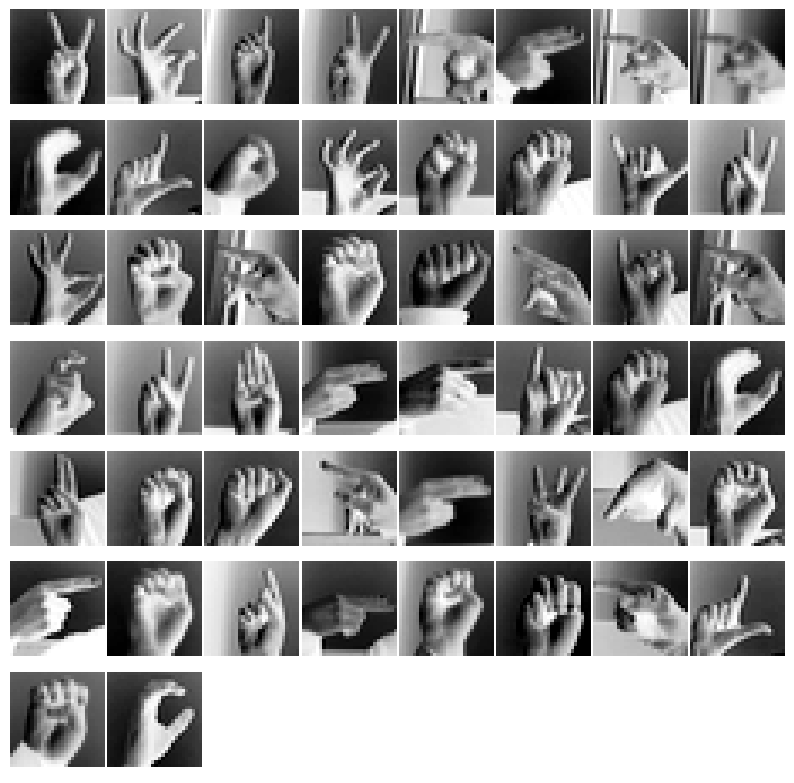

In [19]:
# Seleccionar datos aleatoriamente
X_sample, y_sample = select_random_data(X_test, y_test, m_test)

# Graficar resultados
plot_results(X_sample, y_sample, all_theta)